In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from math import sqrt

<AxesSubplot:xlabel='Date'>

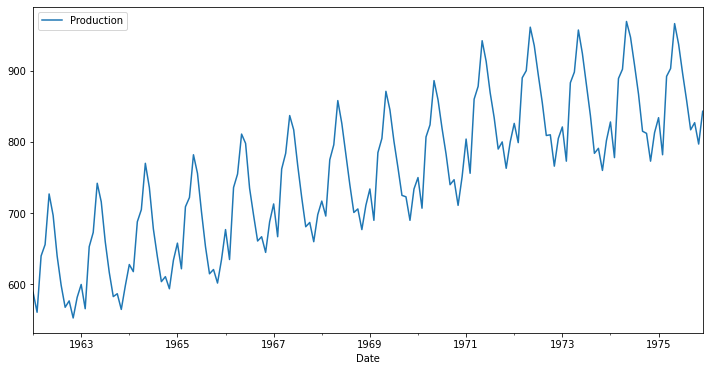

In [40]:
df = pd.read_csv('LSTM_tutorial.csv', index_col='Date', parse_dates=True)
df.index.freq = 'MS'
df.plot(figsize=(12,6))

In [41]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


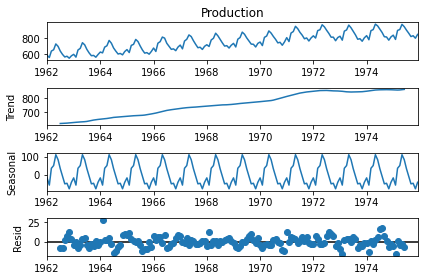

In [8]:
results = seasonal_decompose(df['Production'])
results.plot();

In [9]:
len(df)

168

In [14]:
train = df.iloc[:156]
test = df.iloc[156:]

In [15]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [16]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [21]:
# define generator
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [23]:
X, y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')


Given the Array: 
[0.08653846 0.01923077 0.20913462 0.24759615 0.41826923 0.34615385
 0.20913462 0.11057692 0.03605769 0.05769231 0.         0.06971154]
Predict this y: 
 [[0.11298077]]


In [24]:
X.shape

(1, 12, 1)

In [25]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [26]:
# fit model
model.fit(generator,epochs=20)

Epoch 1/20
144/144 [==============================] - 2s 5ms/step - loss: 0.0307
Epoch 2/20
144/144 [==============================] - 1s 5ms/step - loss: 0.0256
Epoch 3/20
144/144 [==============================] - 1s 4ms/step - loss: 0.0190
Epoch 4/20
144/144 [==============================] - 1s 4ms/step - loss: 0.0144
Epoch 5/20
144/144 [==============================] - 1s 5ms/step - loss: 0.0066
Epoch 6/20
144/144 [==============================] - 1s 4ms/step - loss: 0.0076
Epoch 7/20
144/144 [==============================] - 1s 4ms/step - loss: 0.0055
Epoch 8/20
144/144 [==============================] - 1s 4ms/step - loss: 0.0046
Epoch 9/20
144/144 [==============================] - 1s 4ms/step - loss: 0.0052
Epoch 10/20
144/144 [==============================] - 1s 5ms/step - loss: 0.0034
Epoch 11/20
144/144 [==============================] - 1s 5ms/step - loss: 0.0038
Epoch 12/20
144/144 [==============================] - 1s 7ms/step - loss: 0.0033
Epoch 13/20
144/144 [====

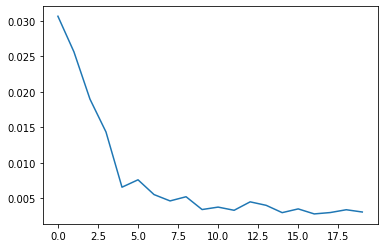

In [27]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [32]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
for i in range(len(test)):
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    # append the prediction into the array
    test_predictions.append(current_pred) 
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [33]:
test_predictions

[array([0.62717104], dtype=float32),
 array([0.6567939], dtype=float32),
 array([0.82590574], dtype=float32),
 array([0.93248487], dtype=float32),
 array([1.0295022], dtype=float32),
 array([1.0223684], dtype=float32),
 array([0.949526], dtype=float32),
 array([0.809514], dtype=float32),
 array([0.7040362], dtype=float32),
 array([0.63948315], dtype=float32),
 array([0.6034851], dtype=float32),
 array([0.61560553], dtype=float32)]

In [34]:
true_predictions = scaler.inverse_transform(test_predictions)

In [35]:
test['Predictions'] = true_predictions

C:\Users\Matija\AppData\Local\Temp\ipykernel_10316\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<AxesSubplot:xlabel='Date'>

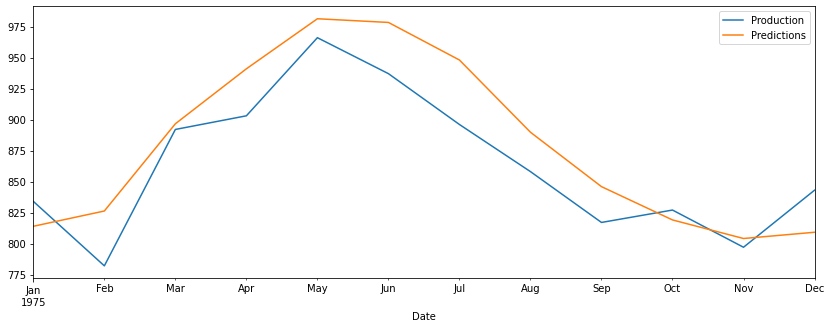

In [36]:
test.plot(figsize=(14,5))

In [39]:
rmse = sqrt(mean_squared_error(test['Production'], test['Predictions']))
print(rmse)


31.047730988666647
